# Movie Ratings Analysis (MovieLens 200k)

Sebastian Ramos — Option B: Jupyter Notebook

This notebook answers:
- What’s the breakdown of genres for the movies that were rated?
- Which genres have the highest viewer satisfaction (highest ratings)?
- How does mean rating change across movie release years?
- What are the 5 best-rated movies that have at least 50 ratings? At least 150 ratings?

Notes:
- Movies can belong to multiple genres; exploding genres is used for preference profiling.
- Minimum sample thresholds are applied to reduce small-sample noise.


In [11]:
# Imports and plot style

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set_theme(style="whitegrid", context="notebook")
sns.set_palette("tab10")
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:,.3f}'.format

def wrap_labels(ax, width=18):
    for label in ax.get_xticklabels():
        text = label.get_text()
        if len(text) > width:
            parts = []
            while len(text) > width:
                split_at = text[:width].rfind(' ')
                split_at = split_at if split_at != -1 else width
                parts.append(text[:split_at])
                text = text[split_at:].lstrip()
            parts.append(text)
            label.set_text("\n".join(parts))
    ax.figure.canvas.draw_idle()


In [12]:
# Paths and parameters
DATA_PATH = 'data/movie_ratings.csv'

# Thresholds
GENRE_MIN_N = 100  # min ratings per genre to include in satisfaction chart
YEAR_MIN_N = 50    # min ratings per release year to include
TOP_MIN_1 = 50     # min ratings for top-5 list #1
TOP_MIN_2 = 150    # min ratings for top-5 list #2


## Load and clean data

In [13]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

# Coerce dtypes
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')
if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['title'] = df.get('title', '').astype(str)
df['genres'] = df.get('genres', '').fillna("").astype(str)

# Parse timestamp if present
if 'timestamp' in df.columns:
    if np.issubdtype(df['timestamp'].dtype, np.number):
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    else:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Explode genres for per-genre analysis
df['genre_list'] = df['genres'].str.split('|')
df_exploded = df.explode('genre_list', ignore_index=True).rename(columns={'genre_list': 'genre'})
df_exploded['genre'] = df_exploded['genre'].fillna('Unknown')

# Basic QA
print("Unique users:", df['user_id'].nunique())
print("Unique movies:", df['movie_id'].nunique())
print("Unique genres (exploded):", df_exploded['genre'].nunique())
display(df[['rating','age'] + (["year"] if 'year' in df.columns else [])].describe().T)


Shape: (212595, 13)


,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,title,year,decade,genres,rating_year
0,196,242,3,1997-12-04 15:55:49,49,M,writer,55105,Kolya (1996),"1,996.000","1,990.000",Comedy,1997
1,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),"1,997.000","1,990.000",Crime,1998
2,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),"1,997.000","1,990.000",Film-Noir,1998
3,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),"1,997.000","1,990.000",Mystery,1998
4,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),"1,997.000","1,990.000",Thriller,1998


Unique users: 943
Unique movies: 1682
Unique genres (exploded): 19


,count,mean,std,min,25%,50%,75%,max
rating,"212,595.000",3.551,1.120,1.000,3.000,4.000,4.000,5.000
age,"212,595.000",32.771,11.453,7.000,24.000,30.000,40.000,73.000
year,"212,559.000","1,987.563",13.991,"1,922.000","1,984.000","1,994.000","1,996.000","1,998.000"


## Genre breakdown for rated movies

,genre,n,pct
7,Drama,39895,0.188
4,Comedy,29832,0.140
0,Action,25589,0.120
15,Thriller,21872,0.103
13,Romance,19461,0.092
1,Adventure,13753,0.065
14,Sci-Fi,12730,0.060
16,War,9398,0.044
5,Crime,8055,0.038
3,Children,7182,0.034


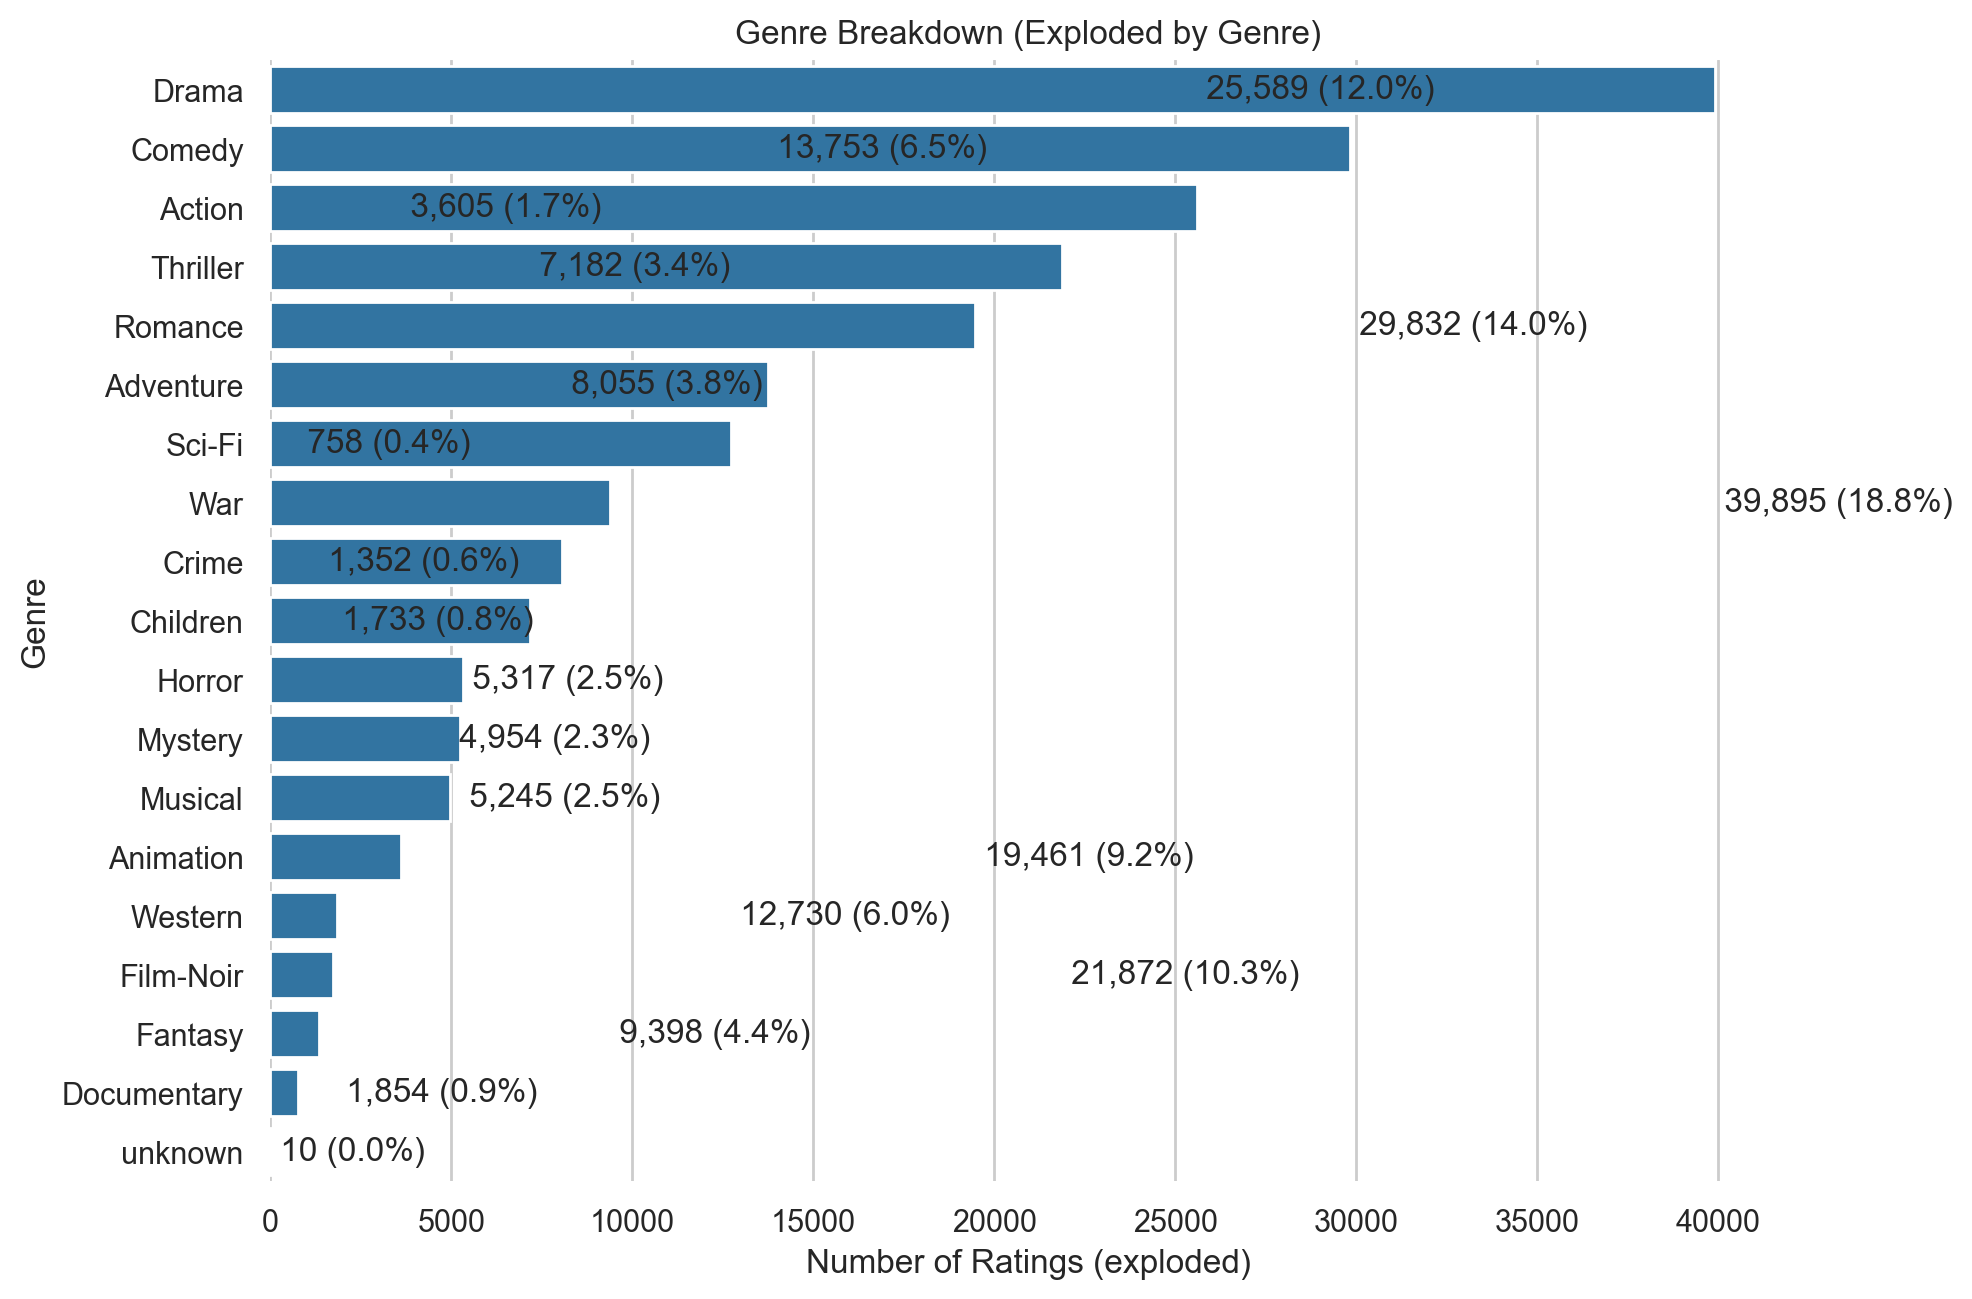

In [14]:
genre_counts = (
    df_exploded.groupby('genre', dropna=False)
      .size()
      .reset_index(name='n')
      .sort_values('n', ascending=False)
)
genre_counts['pct'] = genre_counts['n'] / genre_counts['n'].sum()
display(genre_counts.head(20))

fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(genre_counts))))
sns.barplot(data=genre_counts, y='genre', x='n', ax=ax, order=genre_counts['genre'])
ax.set_title('Genre Breakdown (Exploded by Genre)')
ax.set_xlabel('Number of Ratings (exploded)')
ax.set_ylabel('Genre')
for i, row in genre_counts.iterrows():
    ax.text(row['n'], i, f" {row['n']:,} ({row['pct']:.1%})", va='center')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## Genres with highest viewer satisfaction (mean ratings)
Minimum sample size applied (n ≥ 100 by default).

,genre,mean_rating,n,std,sem,ci95
9,Film-Noir,3.922,1733,0.993,0.024,0.047
16,War,3.816,9398,1.080,0.011,0.022
7,Drama,3.687,39895,1.079,0.005,0.011
6,Documentary,3.673,758,1.180,0.043,0.084
12,Mystery,3.638,5245,1.091,0.015,0.030
5,Crime,3.632,8055,1.113,0.012,0.024
13,Romance,3.622,19461,1.096,0.008,0.015
17,Western,3.613,1854,1.042,0.024,0.047
2,Animation,3.577,3605,1.097,0.018,0.036
14,Sci-Fi,3.561,12730,1.133,0.010,0.020


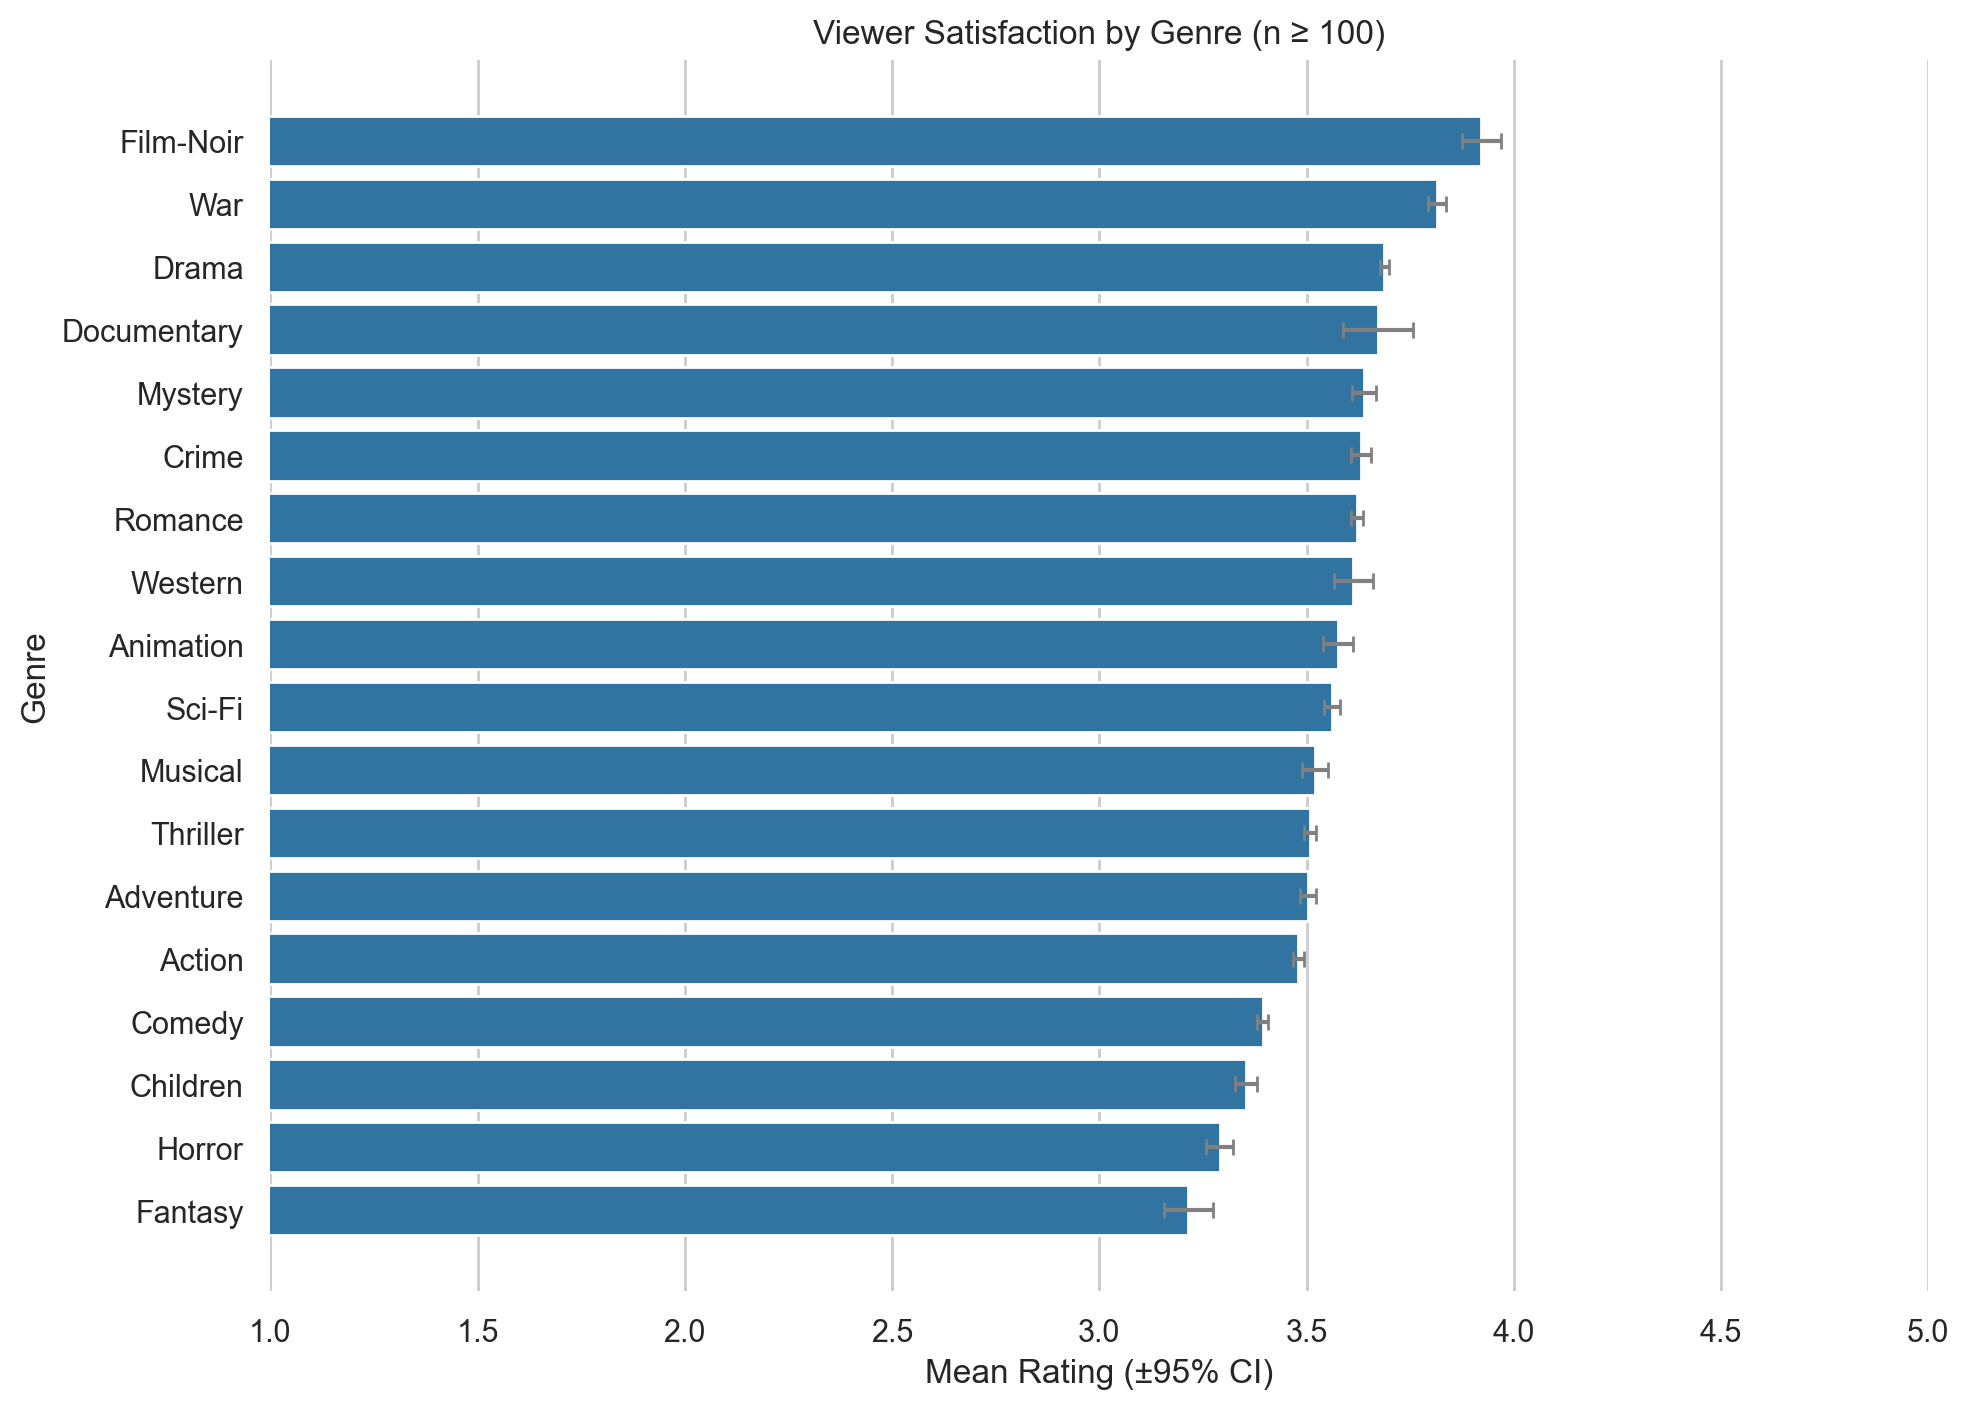

In [15]:
genre_stats = (
    df_exploded.dropna(subset=['rating'])
      .groupby('genre')
      .agg(mean_rating=('rating','mean'), n=('rating','size'), std=('rating','std'))
      .reset_index()
)
genre_stats['sem'] = genre_stats['std'] / np.sqrt(genre_stats['n'].clip(lower=1))
genre_stats['ci95'] = 1.96 * genre_stats['sem']

genre_stats_f = genre_stats.query('n >= @GENRE_MIN_N').sort_values('mean_rating', ascending=False)
display(genre_stats_f.head(15))

fig, ax = plt.subplots(figsize=(10, max(4, 0.4*len(genre_stats_f))))
sns.barplot(
    data=genre_stats_f,
    y='genre', x='mean_rating', ax=ax,
    order=genre_stats_f['genre']
)
ax.errorbar(
    x=genre_stats_f['mean_rating'],
    y=np.arange(len(genre_stats_f)),
    xerr=genre_stats_f['ci95'], fmt='none', ecolor='gray', capsize=3
)
ax.set_title(f'Viewer Satisfaction by Genre (n ≥ {GENRE_MIN_N})')
ax.set_xlabel('Mean Rating (±95% CI)')
ax.set_ylabel('Genre')
ax.set_xlim(1, 5)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## Mean rating across movie release years
Years with at least 50 ratings are shown; a rolling average smooths noise.

,year,mean_rating,n,mean_roll_5
66,"1,994.000",3.427,18046,3.425
67,"1,995.000",3.443,25229,3.404
68,"1,996.000",3.312,37505,3.366
69,"1,997.000",3.325,33760,3.351
70,"1,998.000",3.324,1938,3.320


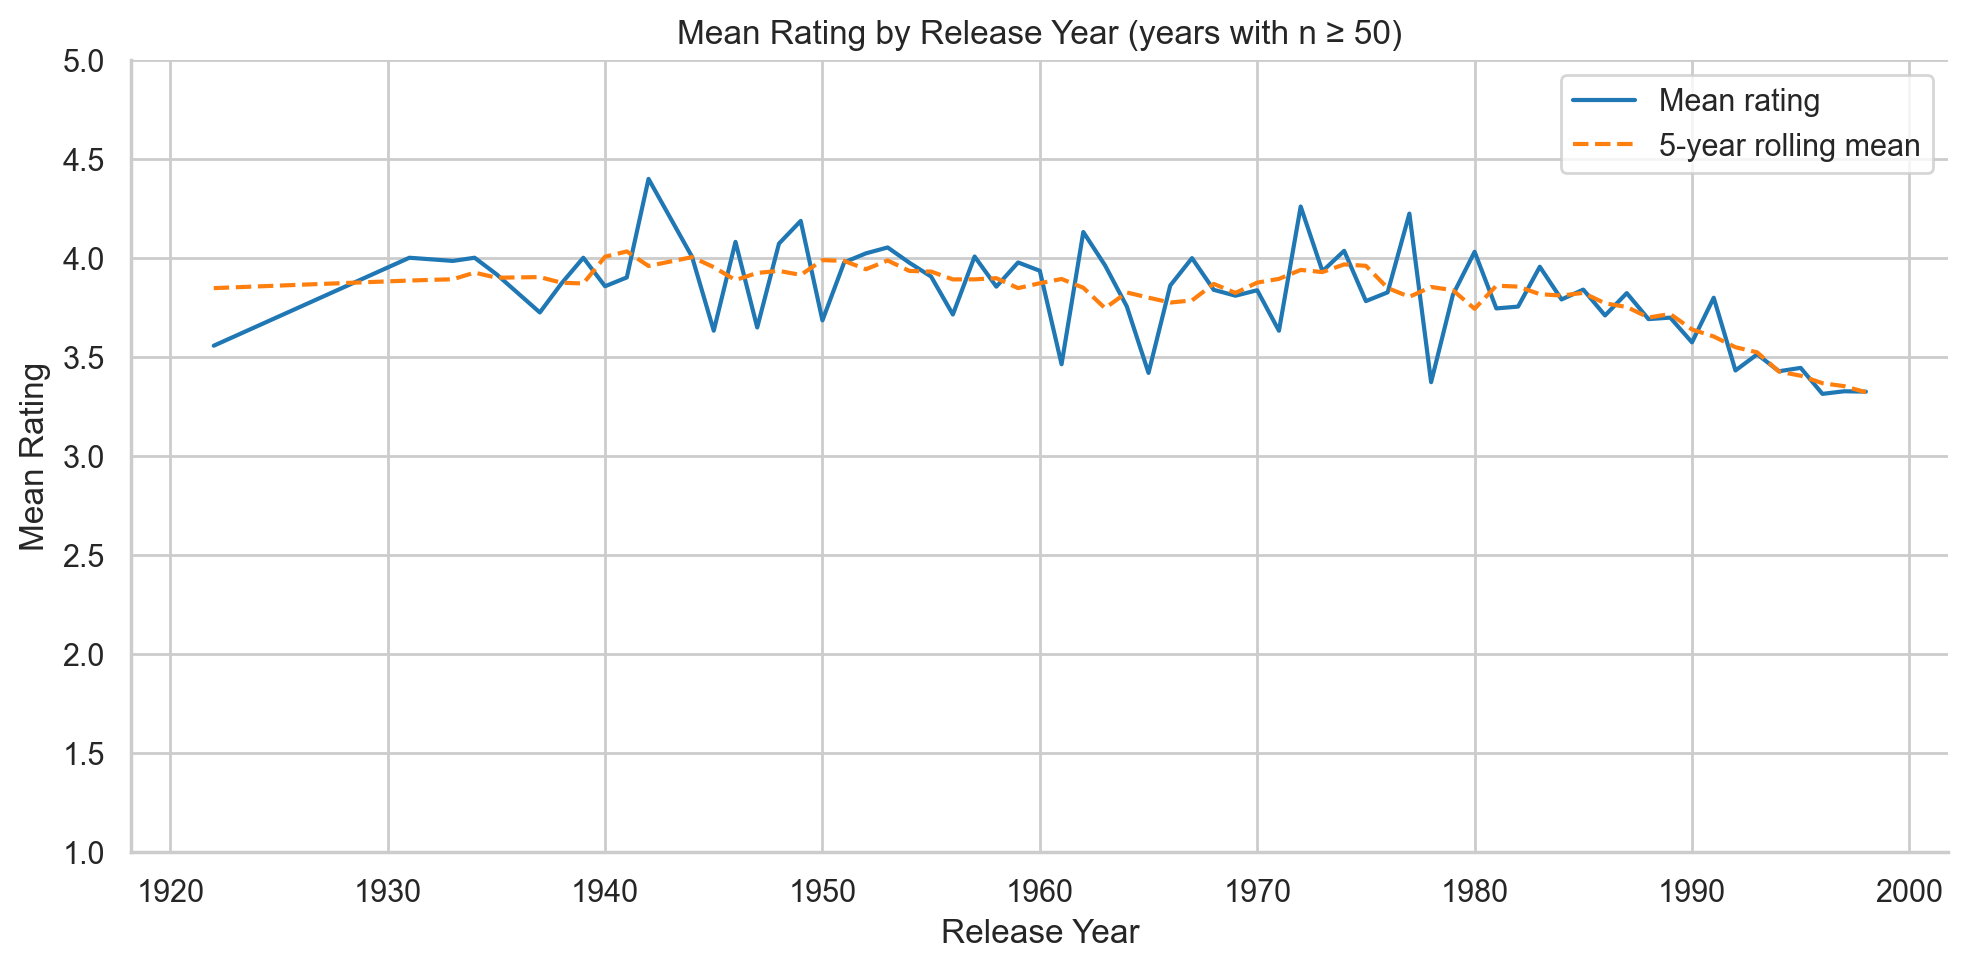

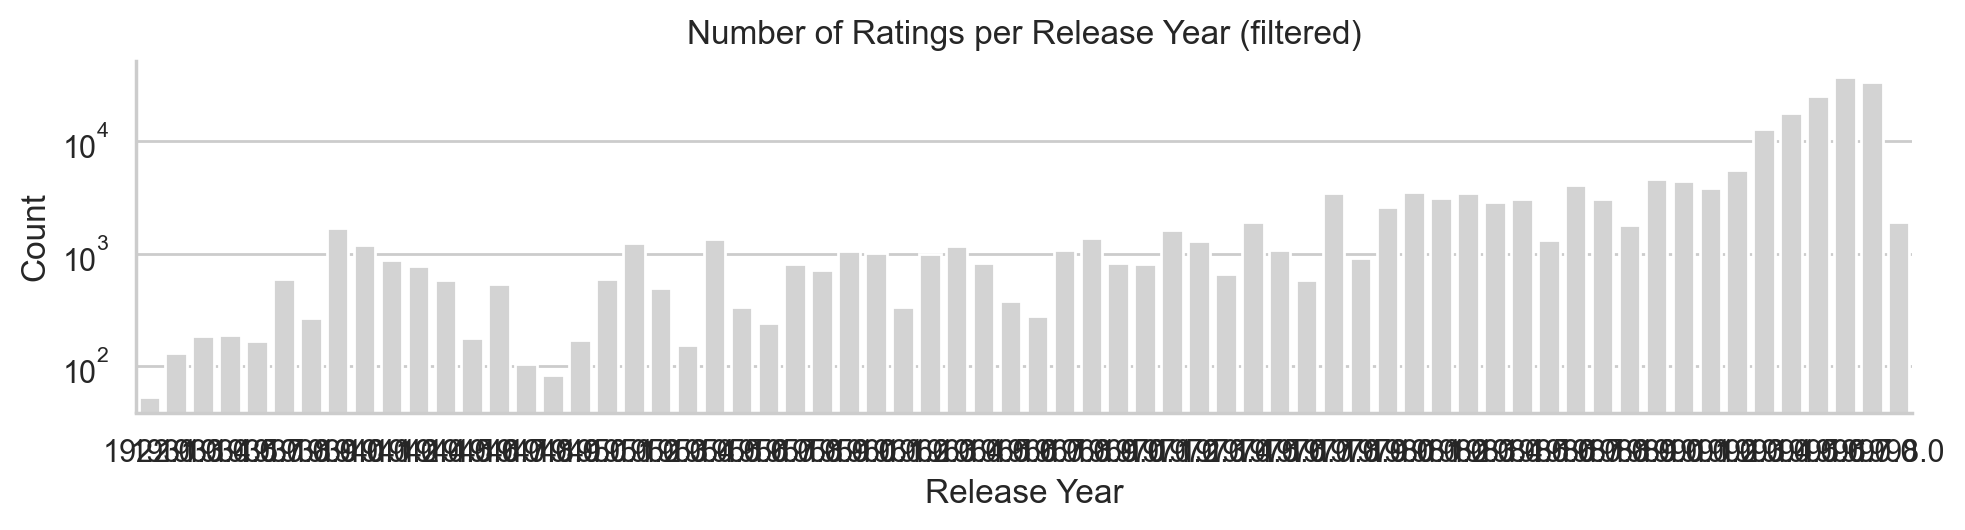

In [17]:
if 'year' in df_exploded.columns:
    by_year = (
        df_exploded.dropna(subset=['year','rating'])
          .groupby('year')
          .agg(mean_rating=('rating','mean'), n=('rating','size'))
          .reset_index()
          .sort_values('year')
    )
    by_year_f = by_year.query('n >= @YEAR_MIN_N').copy()
    by_year_f['mean_roll_5'] = by_year_f['mean_rating'].rolling(5, center=True, min_periods=1).mean()
    display(by_year_f.tail())

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=by_year_f, x='year', y='mean_rating', ax=ax, label='Mean rating')
    sns.lineplot(data=by_year_f, x='year', y='mean_roll_5', ax=ax, label='5-year rolling mean', linestyle='--')
    ax.set_title(f'Mean Rating by Release Year (years with n ≥ {YEAR_MIN_N})')
    ax.set_ylabel('Mean Rating')
    ax.set_xlabel('Release Year')
    ax.set_ylim(1, 5)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Counts per year (context)
    fig, ax = plt.subplots(figsize=(10, 2.8))
    sns.barplot(data=by_year_f, x='year', y='n', ax=ax, color='lightgray')
    ax.set_title('Number of Ratings per Release Year (filtered)')
    ax.set_ylabel('Count')
    ax.set_xlabel('Release Year')
    ax.set_yscale('log')
    sns.despine()
    plt.tight_layout()
    plt.show()
else:
    print('No release year column found.')


## Best-rated movies (min 50 and 150 ratings)
Top 5 by mean rating; ties broken by number of ratings.

Top 5 movies with at least 50 ratings:


,movie_id,title,year,mean_rating,n_ratings
406,408,"Close Shave, A (1995)","1,995.000",4.491,336
316,318,Schindler's List (1993),"1,993.000",4.466,596
168,169,"Wrong Trousers, The (1993)","1,993.000",4.466,236
481,483,Casablanca (1942),"1,942.000",4.457,729
113,114,Wallace & Gromit: The Best of Aardman Animatio...,"1,996.000",4.448,67


Top 5 movies with at least 150 ratings:


,movie_id,title,year,mean_rating,n_ratings
406,408,"Close Shave, A (1995)","1,995.000",4.491,336
316,318,Schindler's List (1993),"1,993.000",4.466,596
168,169,"Wrong Trousers, The (1993)","1,993.000",4.466,236
481,483,Casablanca (1942),"1,942.000",4.457,729
63,64,"Shawshank Redemption, The (1994)","1,994.000",4.445,283


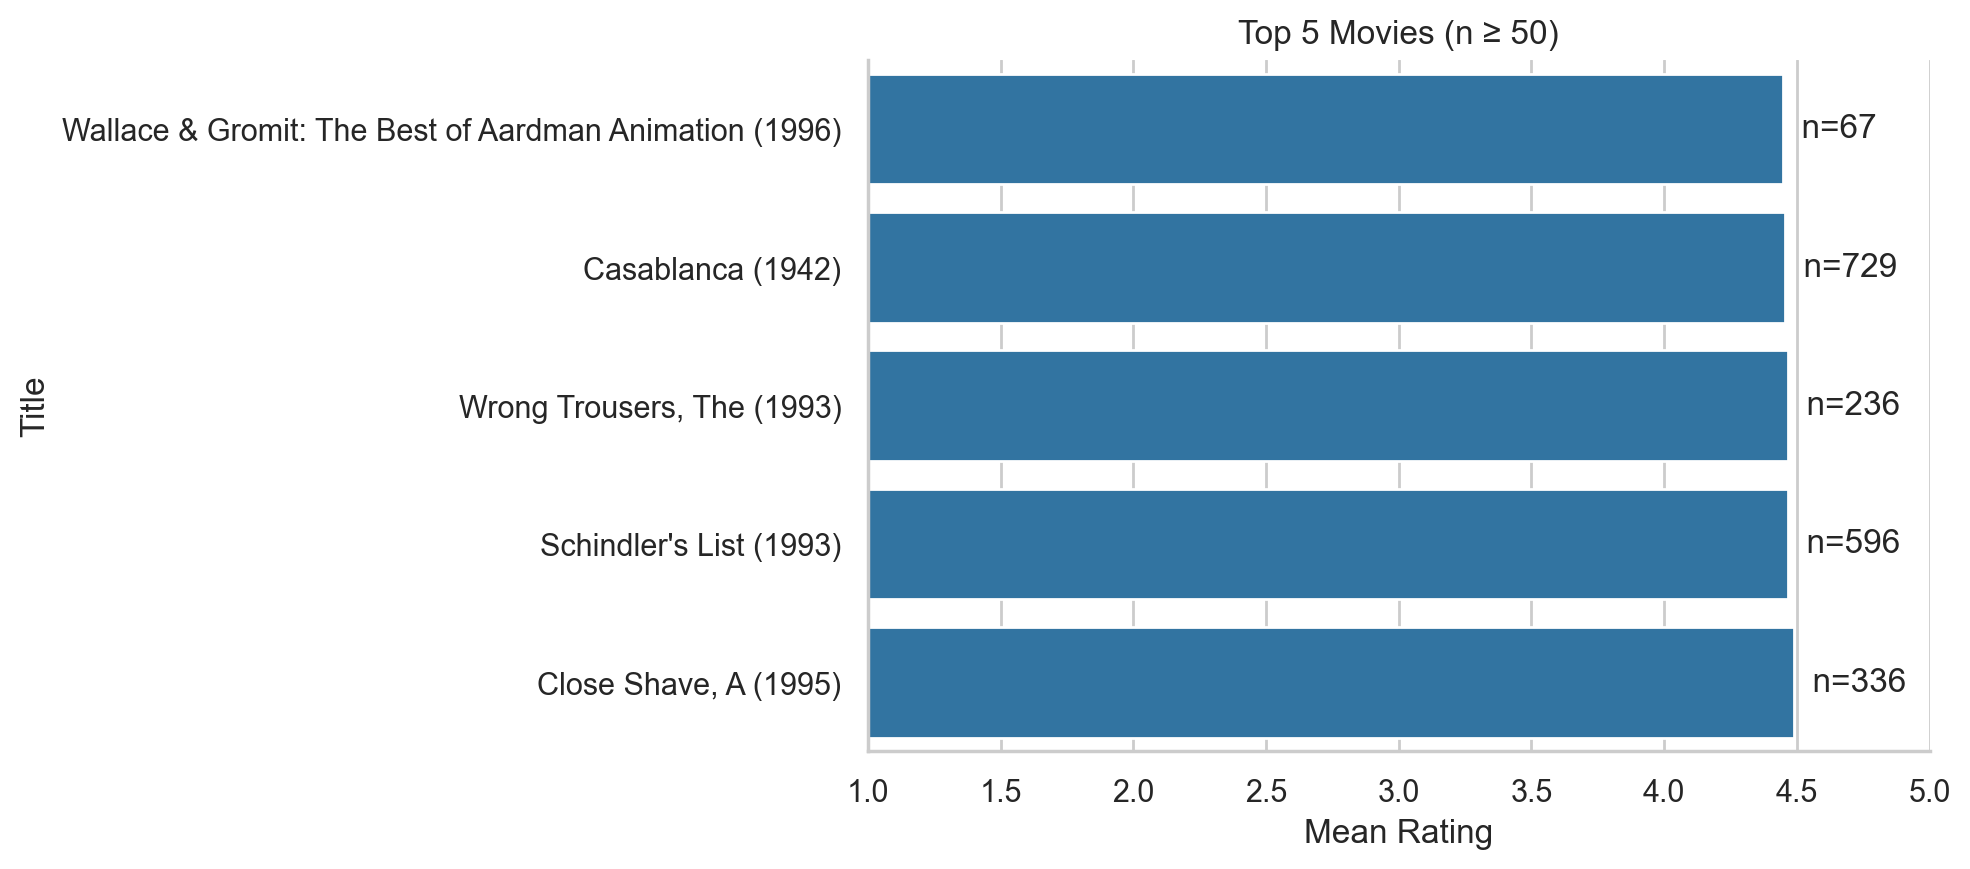

In [18]:
movie_stats = (
    df.groupby(['movie_id','title','year'] if 'year' in df.columns else ['movie_id','title'])
      .agg(mean_rating=('rating','mean'), n_ratings=('rating','size'))
      .reset_index()
)

top_50 = (
    movie_stats.query('n_ratings >= @TOP_MIN_1')
    .sort_values(['mean_rating','n_ratings'], ascending=[False, False])
    .head(5)
)
top_150 = (
    movie_stats.query('n_ratings >= @TOP_MIN_2')
    .sort_values(['mean_rating','n_ratings'], ascending=[False, False])
    .head(5)
)

print(f"Top 5 movies with at least {TOP_MIN_1} ratings:")
display(top_50)
print(f"Top 5 movies with at least {TOP_MIN_2} ratings:")
display(top_150)

# Optional visualization for the >=50 group
fig, ax = plt.subplots(figsize=(10, 4.5))
plot_df = top_50.sort_values('mean_rating')
sns.barplot(data=plot_df, y='title', x='mean_rating', ax=ax)
for i, r in plot_df.iterrows():
    ax.text(r['mean_rating'], list(plot_df['title']).index(r['title']), f"  n={int(r['n_ratings'])}", va='center')
ax.set_title(f'Top 5 Movies (n ≥ {TOP_MIN_1})')
ax.set_xlabel('Mean Rating')
ax.set_ylabel('Title')
ax.set_xlim(1, 5)
sns.despine()
plt.tight_layout()
plt.show()


### Conclusions
- Genre breakdown shows which categories dominate ratings volume.
- Satisfaction ranks genres by mean rating with confidence intervals and minimum n.
- Mean rating by release year shows temporal trends; counts provide context.
- Top movies include minimum sample thresholds to avoid small-sample bias.
